# Predictive Sales using simple Linear Regressions
From daily historical data of sales from January 2013 to October 2015, <br>
the goal is to forecast the sales for the shops and products for November 2015.  <br>
![Best_Seller](https://i.ebayimg.com/images/g/GkEAAOSwxH1ULE5R/s-l300.jpg)

In [1]:
import numpy as np
import pandas as pd
#from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load Data

In [2]:
# Data path
path = '/kaggle/input/competitive-data-science-predict-future-sales/'

#Load
train = pd.read_csv(path + 'sales_train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
items = pd.read_csv(path + 'items.csv')
item_categories = pd.read_csv(path + 'item_categories.csv')
shops = pd.read_csv(path + 'shops.csv')

**Look at data**

In [3]:
#look at data
print("************** SALES_TRAIN **************")
print(train.describe())
print(train.head(6))
print("************** TEST **************")
print(test.head(3))
print(test.describe())
#print(test[46359:46362])
#print(test[45:65])
print("************** OTHERS **************")
print(sample_submission.head(3))
print(items.head(1))
print(item_categories.head(1))
print(shops.head(1))

************** SALES_TRAIN **************
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0     

**Validate Data**

In [4]:
#check nulls
print("Check for Nulls:")
print(train.isnull().sum())
print(test.isnull().sum())

Check for Nulls:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
ID         0
shop_id    0
item_id    0
dtype: int64


In [5]:
#Difference Stores and Items between train and test sets
dif1_a = list(set(train['shop_id']) - set(test['shop_id']))
print("Dif shop_id - TRAIN NOT TEST: ", dif1_a)

dif1_b = list(set(test['shop_id']) - set(train['shop_id']))
print("Dif shop_id - TEST NOT TRAIN: ", dif1_b)

dif2_a = list(set(train['item_id']) - set(test['item_id']))
print("Amount Dif item_id - TRAIN NOT TEST: ", len(dif2_a))

dif2_b = list(set(test['item_id']) - set(train['item_id']))
print("Amount Dif item_id - TEST NOT TRAIN: ", len(dif2_b))

print("There are ", len(dif2_a), " items not sold and " , len(dif2_b) ," new.")

Dif shop_id - TRAIN NOT TEST:  [0, 1, 32, 33, 8, 9, 40, 11, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30]
Dif shop_id - TEST NOT TRAIN:  []
Amount Dif item_id - TRAIN NOT TEST:  17070
Amount Dif item_id - TEST NOT TRAIN:  363
There are  17070  items not sold and  363  new.


# Data Cleaning and Analysis

**Group data to useful sets**

In [6]:
#Groupby boughts on the same month
train_grouped_d_s = train.groupby(["date_block_num", "shop_id"], as_index=False)["item_cnt_day"].sum()
train_grouped_d_i = train.groupby(["date_block_num", "item_id"], as_index=False)["item_cnt_day"].sum()
train_grouped_d_s_i = train.groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"].sum()
train_grouped_d = train.groupby(["date_block_num"], as_index=False)["item_cnt_day"].sum()
print("************** GROUPED BY DATE AND SHOP_ID **************")
print(train_grouped_d_s.describe())
print(train_grouped_d_s.head(3))
print("************** GROUPED BY DATE AND ITEM_ID **************")
print(train_grouped_d_i.describe())
print(train_grouped_d_i.head(3))
print("************** GROUPED BY DATE AND SHOP_ID AND ITEM_ID **************")
print(train_grouped_d_s_i.describe())
print(train_grouped_d_s_i.head(3))
print("************** GROUPED BY DATE **************")
print(train_grouped_d.describe())
print(train_grouped_d.head(3))

************** GROUPED BY DATE AND SHOP_ID **************
       date_block_num      shop_id  item_cnt_day
count     1586.000000  1586.000000    1586.00000
mean        16.476040    31.302018    2300.25599
std          9.644913    17.350139    1906.64723
min          0.000000     0.000000      -1.00000
25%          8.000000    16.000000    1185.25000
50%         17.000000    31.000000    1737.50000
75%         25.000000    47.000000    2599.00000
max         33.000000    59.000000   16318.00000
   date_block_num  shop_id  item_cnt_day
0               0        0        5578.0
1               0        1        2947.0
2               0        2        1146.0
************** GROUPED BY DATE AND ITEM_ID **************
       date_block_num        item_id   item_cnt_day
count   233912.000000  233912.000000  233912.000000
mean        14.941944   11308.922377      15.596489
std          9.642430    6208.348238      96.125890
min          0.000000       0.000000     -22.000000
25%          7.0000

In [7]:
#Groupby boughts of the same item and/or shop
train_grouped_s = train.groupby(["shop_id"], as_index=False)["item_cnt_day"].sum()
train_grouped_i = train.groupby(["item_id"], as_index=False)["item_cnt_day"].sum()
train_grouped_s_i = train.groupby(["shop_id","item_id"], as_index=False)["item_cnt_day"].sum()
print("************** GROUPED BY SHOP_ID **************")
print(train_grouped_s.describe())
print(train_grouped_s.head(3))
print("************** GROUPED BY ITEM_ID **************")
print(train_grouped_i.describe())
print(train_grouped_i.head(3))
print("************** GROUPED BY SHOP_ID AND ITEM_ID **************")
print(train_grouped_s_i.describe())
print(train_grouped_s_i.head(3))

************** GROUPED BY SHOP_ID **************
         shop_id   item_cnt_day
count  60.000000      60.000000
mean   29.500000   60803.433333
std    17.464249   57992.901750
min     0.000000     330.000000
25%    14.750000   23333.000000
50%    29.500000   50176.000000
75%    44.250000   69562.250000
max    59.000000  310777.000000
   shop_id  item_cnt_day
0        0       11705.0
1        1        6311.0
2        2       30620.0
************** GROUPED BY ITEM_ID **************
            item_id  item_cnt_day
count  21807.000000   21807.00000
mean   11098.699271     167.29518
std     6397.059362    1366.22019
min        0.000000     -11.00000
25%     5551.500000       7.00000
50%    11105.000000      33.00000
75%    16647.500000     124.00000
max    22169.000000  187642.00000
   item_id  item_cnt_day
0        0           1.0
1        1           6.0
2        2           2.0
************** GROUPED BY SHOP_ID AND ITEM_ID **************
             shop_id        item_id   item_cnt_

**Check Outliers**

Text(0.5, 0.98, 'Solds per Shop')

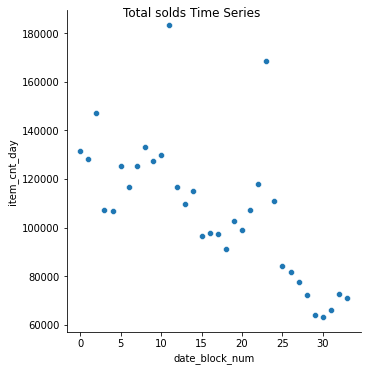

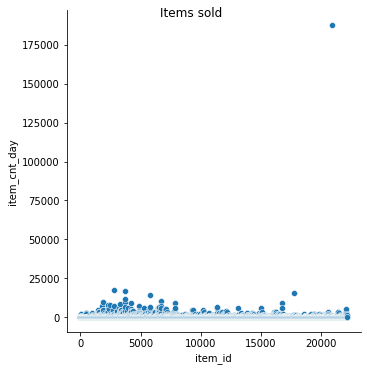

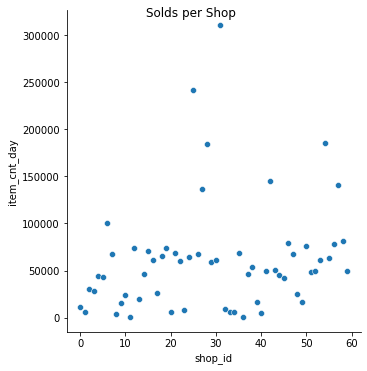

In [8]:
#PLOT MONTLY TOTAL ITEMS SOLD - cheack seasonality
fig1 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d)
fig1a = fig1.fig 
fig1a.suptitle("Total solds Time Series", fontsize=12)

#ITEMS SOLD PER ID - check outliers
fig2 = sns.relplot(x='item_id', y='item_cnt_day', data=train_grouped_i)
fig2a = fig2.fig 
fig2a.suptitle("Items sold", fontsize=12)

#ITEMS SOLD PER STORE - check outliers
fig3 = sns.relplot(x='shop_id', y='item_cnt_day', data=train_grouped_s)
fig3a = fig3.fig 
fig3a.suptitle("Solds per Shop", fontsize=12)

In [9]:
#Check what items are outliers
print("*** Item outlier ***")
for i in range(1,len(train_grouped_i)):
    if train_grouped_i.iloc[i,1] >=25000: 
        print(train_grouped_i.iloc[i,0] , " -> " , items.iloc[i,0])
                
#Check what stores were outliers
print("*** Biggest shop ***")
for i in range(1,len(train_grouped_s)):
    if train_grouped_s.iloc[i,1] >=250000: 
        print(train_grouped_s.iloc[i,0] , " -> " , shops.iloc[i,0])

*** Item outlier ***
20949  ->  Фигурка Marvel Universe Deadpool POP 3,75"
*** Biggest shop ***
31  ->  Москва ТЦ "Семеновский"


*** Check if Best Seller item (outlier) is 'legitim' ***
*** Check Biggest shop follows the typical trend ***
*** Check Best Seller item at Biggest shop ***


Text(0.5, 0.98, 'Solds of item 20949 at Shop 31')

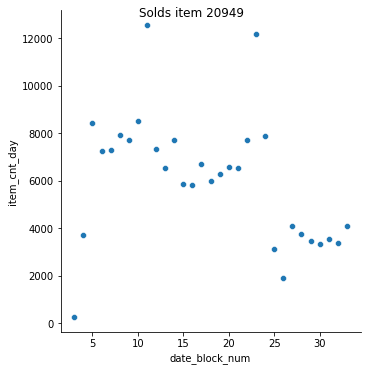

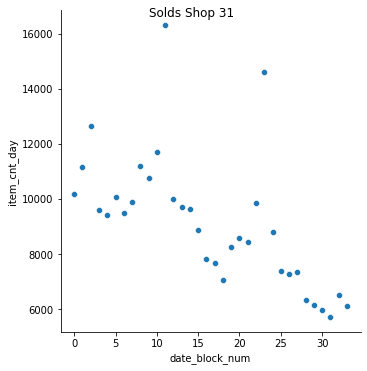

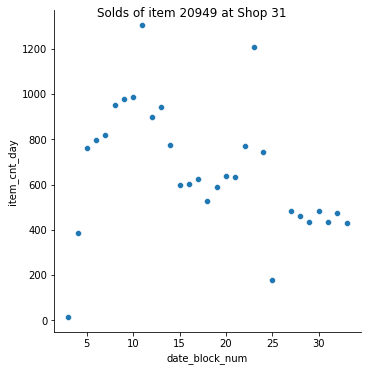

In [10]:
#Check if item outlier is legitim
print("*** Check if Best Seller item (outlier) is 'legitim' ***")                               
#ITEMS SOLD PER ID 20949
fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 20949])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 20949", fontsize=12)

print("*** Check Biggest shop follows the typical trend ***")   
#SHOPS SOLD PER SHOP 31
fig5 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s.loc[train_grouped_d_s['shop_id'] == 31])
fig5a = fig5.fig 
fig5a.suptitle("Solds Shop 31", fontsize=12)

print("*** Check Best Seller item at Biggest shop ***")  
#TEMS SOLD AT SHOP 31
fig6 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s_i.loc[(train_grouped_d_s_i['item_id'] == 20949) & (train_grouped_d_s_i['shop_id'] == 31)])
fig6a = fig6.fig 
fig6a.suptitle("Solds of item 20949 at Shop 31", fontsize=12)


There was a item identified as outlier (id=20949), but it seems legitim. <br>
The largest shop (shop_id=31) also seems to follow a typical trend. <br>
There are some other shops and items that deserve further investigation. <br>

*** Check other Shops ***


Text(0.5, 0.98, 'Solds of item 20949 at Shop 12')

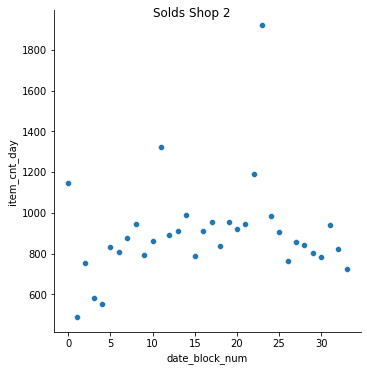

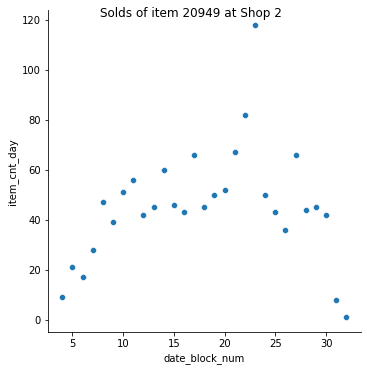

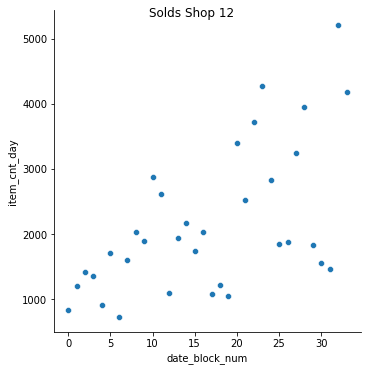

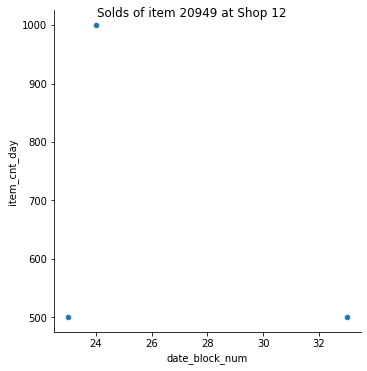

In [11]:
#Check other Shops
print("*** Check other Shops ***")    
fig5 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s.loc[train_grouped_d_s['shop_id'] == 2])
fig5a = fig5.fig 
fig5a.suptitle("Solds Shop 2", fontsize=12)

fig6 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s_i.loc[(train_grouped_d_s_i['item_id'] == 20949) & (train_grouped_d_s_i['shop_id'] == 2)])
fig6a = fig6.fig 
fig6a.suptitle("Solds of item 20949 at Shop 2", fontsize=12)

fig5 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s.loc[train_grouped_d_s['shop_id'] == 12])
fig5a = fig5.fig 
fig5a.suptitle("Solds Shop 12", fontsize=12)

fig6 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s_i.loc[(train_grouped_d_s_i['item_id'] == 20949) & (train_grouped_d_s_i['shop_id'] == 12)])
fig6a = fig6.fig 
fig6a.suptitle("Solds of item 20949 at Shop 12", fontsize=12)

*** Check other items ***
                                              item_name  item_id  \
7223  Uncharted: Натан Дрейк. Коллекция [PS4, русска...     7223   

      item_category_id  
7223                20  
798.0
                                      item_name  item_id  item_category_id
3731  Grand Theft Auto V [PC, русские субтитры]     3731                30
10099.0
                                       item_name  item_id  item_category_id
3733  Grand Theft Auto V [PS4, русские субтитры]     3733                20
6506.0


Text(0.5, 0.98, 'Solds item 3733')

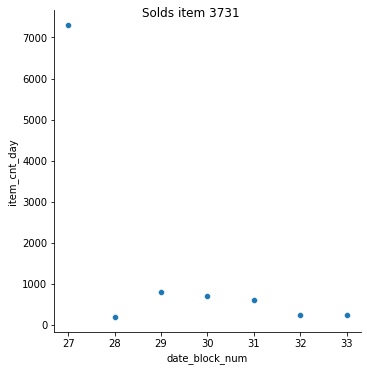

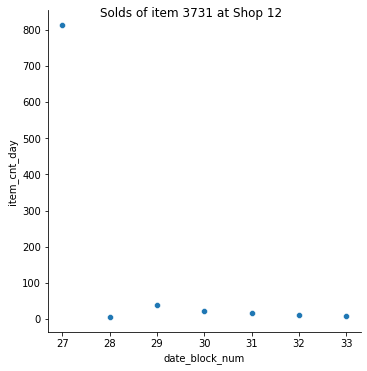

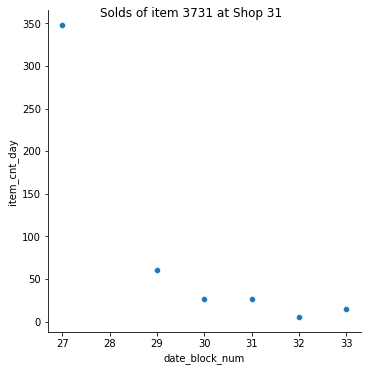

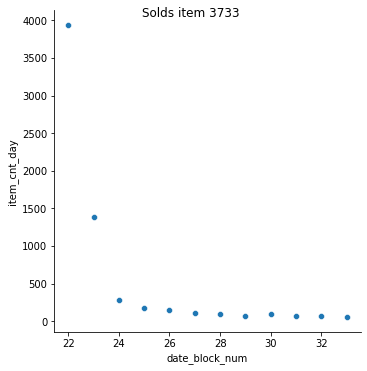

In [12]:
#Check other items outliers 
print("*** Check other items ***")    
print(items.loc[items["item_id"] == 7223])
print(train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 7223, 'item_cnt_day'].sum())
print(items.loc[items["item_id"] == 3731])
print(train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 3731, 'item_cnt_day'].sum())
print(items.loc[items["item_id"] == 3733])
print(train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 3733, 'item_cnt_day'].sum())

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 3731])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 3731", fontsize=12)

fig6 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s_i.loc[(train_grouped_d_s_i['item_id'] == 3731) & (train_grouped_d_s_i['shop_id'] == 12)])
fig6a = fig6.fig 
fig6a.suptitle("Solds of item 3731 at Shop 12", fontsize=12)

fig6 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_s_i.loc[(train_grouped_d_s_i['item_id'] == 3731) & (train_grouped_d_s_i['shop_id'] == 31)])
fig6a = fig6.fig 
fig6a.suptitle("Solds of item 3731 at Shop 31", fontsize=12)

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 3733])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 3733", fontsize=12)


*** Identify type of items atypical ***
10447  ->  ГОЛОВОЛОМКА
17717  ->  Прием денежных средств для 1С-Онлайн
2293  ->  Call of Duty: Advanced Warfare. Day Zero Edition [PC, русская версия]
3460  ->  Far Cry 4. Специальное издание [PC, русская версия]
1555  ->  Assassin's Creed: Единство. Специальное издание [PC, русская версия]
6675  ->  Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)
20404  ->  Фигурка Assassin's Creed Unity Arno The Fearless Assassin 24см
20405  ->  Фигурка Assassin's Creed Unity Elise The Fiery Templar 24см


Text(0.5, 0.98, 'Solds item 20405')

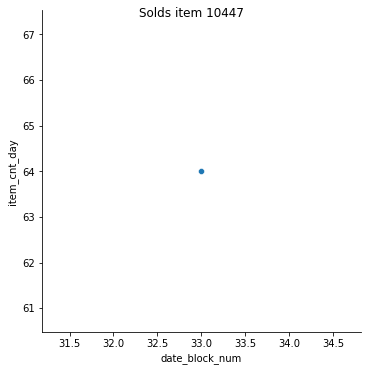

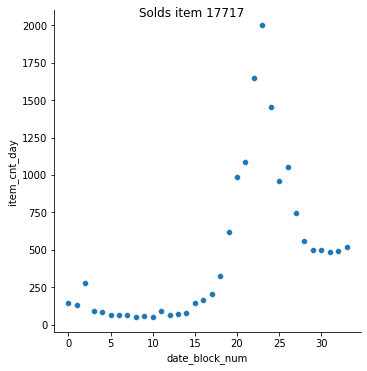

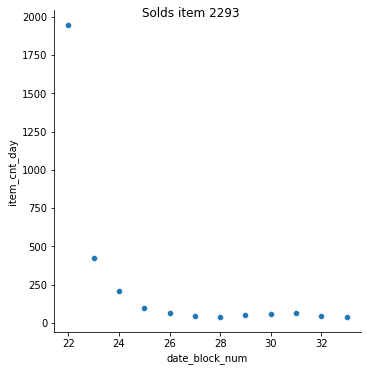

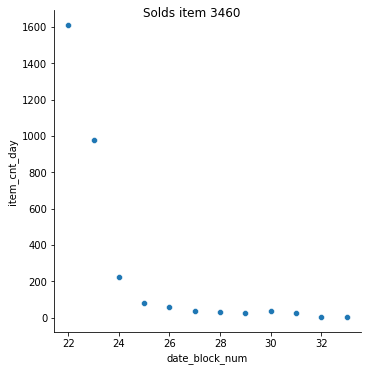

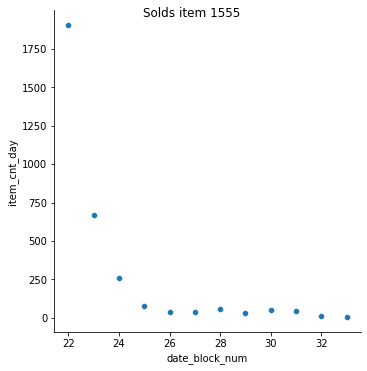

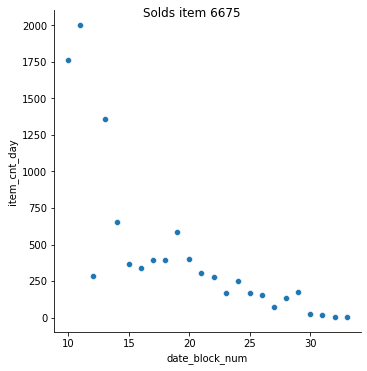

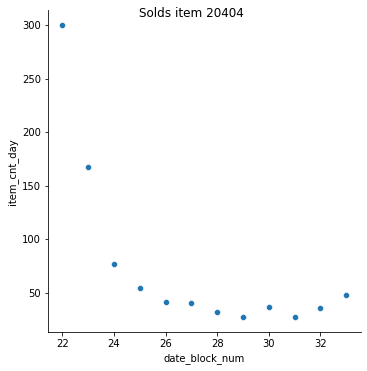

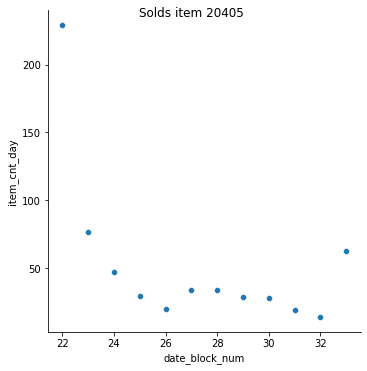

In [13]:
#Check other items atypical 
print("*** Identify type of items atypical ***")  

print(10447, " -> ", items.loc[10447]['item_name'])
print(17717, " -> ", items.loc[17717]['item_name'])
print(2293, " -> ", items.loc[2293]['item_name'])
print(3460, " -> ", items.loc[3460]['item_name'])
print(1555, " -> ", items.loc[1555]['item_name'])

print(6675, " -> ", items.loc[6675]['item_name'])
print(20404, " -> ", items.loc[20404]['item_name'])
print(20405, " -> ", items.loc[20405]['item_name'])

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 10447])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 10447", fontsize=12)

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 17717])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 17717", fontsize=12)

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 2293])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 2293", fontsize=12)

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 3460])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 3460", fontsize=12)

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 1555])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 1555", fontsize=12)


fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 6675])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 6675", fontsize=12)

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 20404])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 20404", fontsize=12)

fig4 = sns.relplot(x='date_block_num', y='item_cnt_day', data=train_grouped_d_i.loc[train_grouped_d_i['item_id'] == 20405])
fig4a = fig4.fig 
fig4a.suptitle("Solds item 20405", fontsize=12)

Most of these are Videogames and have atypical seasonal trends - they could be identified by item_category, but that could cover a very large part of the train set. <br>
These videogames names all share part of their name, regarding their language or translation. <br>
The sells of these type of items will be forecasted only based only on their latter months.

In [14]:
aty_items =  []
print("русские субтитр - Russian subtitles ") 
for i in range(0,len(items['item_name'])):
    txt = items.loc[i]['item_name']
    x = re.search("русские субтитры", txt)
    if x:
        #print(items.loc[i]['item_name'])
        aty_items.append(i)

print("русские субтитр - Russian version ")
for i in range(0,len(items['item_name'])):
    txt = items.loc[i]['item_name']
    x = re.search("русская версия", txt)
    if x:
        #print(items.loc[i]['item_name'])
        aty_items.append(i)
        
print(aty_items)

русские субтитр - Russian subtitles 
русские субтитр - Russian version 
[1242, 1243, 1371, 1372, 1378, 1447, 1448, 1449, 1450, 1480, 1481, 1783, 1790, 1791, 1795, 1799, 1800, 1801, 1802, 1803, 1804, 1807, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1893, 1937, 1939, 1963, 1965, 1969, 1970, 1971, 1987, 1992, 2039, 2040, 2041, 2047, 2058, 2059, 2067, 2068, 2341, 2349, 2376, 2407, 2685, 2687, 2688, 2689, 2690, 2691, 2692, 2694, 2696, 2697, 2698, 2699, 2700, 2703, 2724, 2733, 2740, 2749, 2750, 2751, 2753, 2754, 2755, 2766, 2768, 2772, 2830, 2831, 2832, 2833, 2835, 2836, 2838, 2839, 2844, 2966, 2969, 2971, 2972, 2973, 2974, 2975, 2976, 3017, 3019, 3020, 3021, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3071, 3072, 3073, 3216, 3221, 3223, 3224, 3234, 3236, 3237, 3238, 3239, 3393, 3405, 3407, 3408, 3472, 3477, 3479, 3480, 3719, 3731, 3732, 3733, 3734, 3735, 3753, 3842, 3930, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 4282, 4283, 4330, 4331, 4332, 4333, 4334, 4335, 433

**Drop unused Shops and check final processed data**

In [15]:
#drop Shop that are not in the test set
#[0, 1, 32, 33, 8, 9, 40, 11, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30]
stg_dsi = train_grouped_d_s.copy()
for i in dif1_a:
    stg_dsi.drop(stg_dsi[stg_dsi['shop_id'] == i].index, inplace = True)

#CONFIRM: Difference Stores and Items between train and test sets
dif10_a = list(set(stg_dsi['shop_id']) - set(test['shop_id']))
print("Dif shop_id A: ", dif10_a)

Dif shop_id A:  []


*** All shops ***


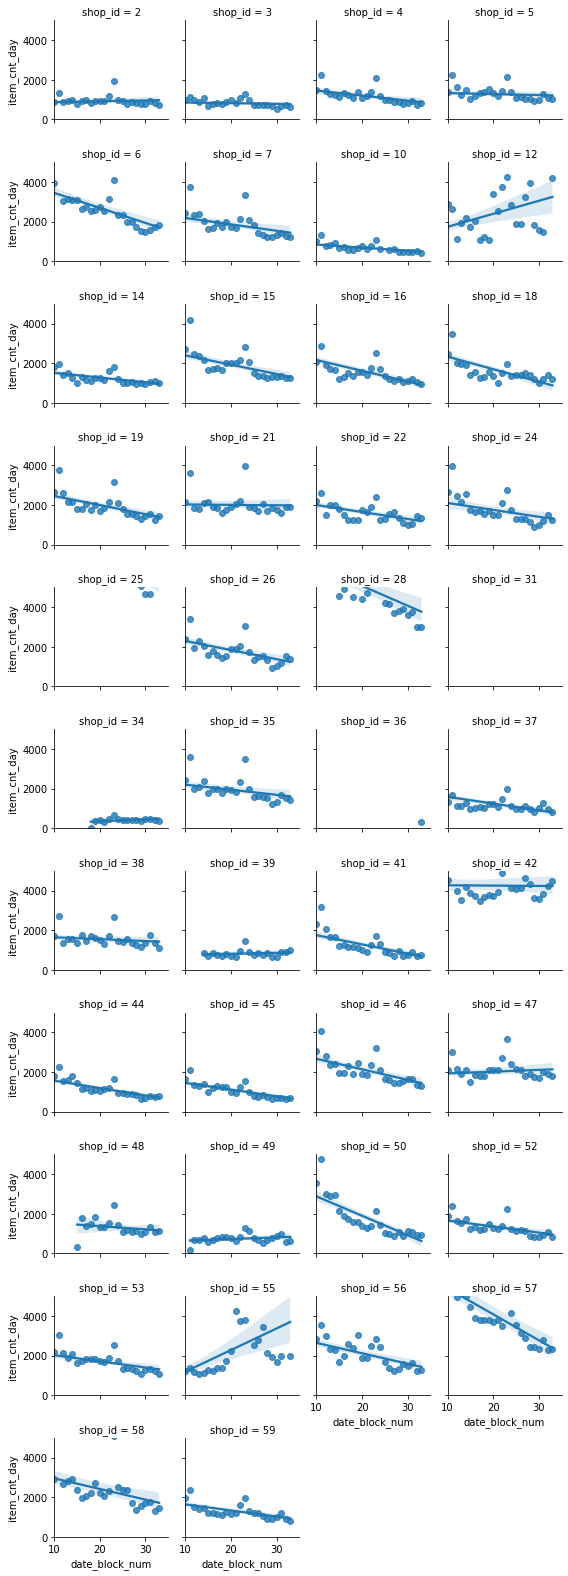

In [16]:
#solds every shops
print("*** All shops ***")   
g = sns.FacetGrid(stg_dsi, col="shop_id", col_wrap=4, height=2,  xlim=(10, 35), ylim=(0, 5000)) #ylim=(-1000, 10000))
g.map(sns.regplot, "date_block_num", "item_cnt_day") #, order=[1, 2, 3], color=".3", ci=None)

There was a item identified as outlier (id=20949), but it was legitime and followed a similar trend as the others. <br>
There are several items, particularly videogames, with a high seasonal trend, that should be taken into account. They were identified through the keywords "subtitles" and "version", in Russian. <br>
There are smaller and larger shops, being the larger one the shop id=31. But its seasonality is similar to the others. <br>
The sells seems to be decreasing. They have a yearly seasonal trend, with a peak around at december, which might be related with the christmas season. The prediction desired is for November, and therefore, the christmas peak could be considered as an outlier. <br>
There are several possible methods to deal with seasonality in time series forecast. Looking at the Figure, it seems reasonable that it could be use the november month alone, from 2014 and 2015, to predict the November 2015 sales. Or simply apply a linear regression with all the months included. Or apply a linear regression for the recent trend, such as considering only the last 3 months.<br>
Or both! Let's do both and average it.

# Regression model

# #1 Considering all months

In [17]:
#1 #Make regression on each shop of the test set 
test_s_list = np.unique(test['shop_id'])
print(test_s_list)

shop_func1 = []
# stg_dsi1 = stg_dsi.loc[(stg_dsi['date_block_num'] == 10) | (stg_dsi['date_block_num'] == 22)]   #IF CONSIDERING ONLY NOVEMBER MONTHS
# stg_dsi1 = stg_dsi.loc[(stg_dsi['date_block_num'] != 11) & (stg_dsi['date_block_num'] != 23)]   #NOT CONSIDERING DECEMBER MONTHS
for j in range(0,len(test_s_list)):
    #if ( (test_s_list[j] == 34) | (test_s_list[j] == 36) | (test_s_list[j] == 39) | (test_s_list[j] == 48) | (test_s_list[j] == 49) ): #don't have both those months      #IF CONSIDERING ONLY NOVEMBER MONTHS
    #    train_shopj1 = stg_dsi.loc[(stg_dsi['shop_id'] == test_s_list[j])]     #IF CONSIDERING ONLY NOVEMBER MONTHS      
    #train_shopj1 = stg_dsi1.loc[(stg_dsi1['shop_id'] == test_s_list[j]) & (stg_dsi1['date_block_num'] >= 1)] #Ignore month 0, contains some 0 data at some shops
    train_shopj1 = stg_dsi.loc[(stg_dsi['shop_id'] == test_s_list[j])]
    t_data1 = np.array(train_shopj1['date_block_num'])
    y_data1 = np.array(train_shopj1['item_cnt_day'])

    def func(t_data1, a, b): 
        #return a * (b ** np.exp(t_data)) + c  #exponential
        return a * t_data1 + b   #linear

    InitialParams1 = [0.1, 1000]
    fitParams1, pcov1 = curve_fit(func, t_data1, y_data1, p0=InitialParams1, method='dogbox')
    
    shop_func1.append(fitParams1)


[ 2  3  4  5  6  7 10 12 14 15 16 18 19 21 22 24 25 26 28 31 34 35 36 37
 38 39 41 42 44 45 46 47 48 49 50 52 53 55 56 57 58 59]


/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [18]:
#2 #TOTAL SELLS IN THE THE MONTH TO PREDICT, for each store
print("November 15th, 2015 , #1 ->")
y_month1 = []

for j in range(0,len(test_s_list)):
    sells1 = shop_func1[j][0] * 34 + shop_func1[j][1]
    print(sells1)
    y_month1.append(sells1)
    #sign if negative
    if sells1 <= 0:
        print(j)

November 15th, 2015 , #1 ->
975.6737975929907
771.4010695187166
847.2727272727279
1209.3181818181818
1627.1069453793957
1406.0588294591778
470.34397855883253
3311.005348538163
943.8074835132286
1272.320853621127
865.7967901032691
818.9251310473096
1357.229948324065
1979.812834224599
1155.3850286468576
1269.3422434655367
5431.090914868631
1193.497326088126
3672.8877069203922
6461.283419103999
488.10000000000025
1580.8181746807109
309.7156880733945
764.8716553762599
1421.3422459893054
879.1105263157892
637.5721937463532
4233.85036712071
664.6363615947537
642.3101604278079
1394.2566844919795
2146.1764705882356
1150.4561313754016
840.537549407115
526.8663104592224
927.7433155080221
1272.8823490533803
3802.519540229885
1377.7379679144392
2249.252004218056
1668.2741920290446
903.9572192513376


# #2 Considering only the last 3 months

In [19]:
#3 #Make regression on each shop of the test set, considering only the last 3 months

shop_func2 = []
for j in range(0,len(test_s_list)):
    train_shopj2 = stg_dsi.loc[(stg_dsi['shop_id'] == test_s_list[j]) & (stg_dsi['date_block_num'] >= 31)]
    t_data2 = np.array(train_shopj2['date_block_num'])
    y_data2 = np.array(train_shopj2['item_cnt_day'])
    
    def func(t_data2, a, b): 
        #return a * (b ** np.exp(t_data)) + c  #exponential
        return a * t_data2 + b   #linear

    InitialParams2 = [0.1, 1000]
    fitParams2, pcov2 = curve_fit(func, t_data2, y_data2, p0=InitialParams2, method='dogbox')
    
    shop_func2.append(fitParams2)


/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [20]:
#4 #TOTAL SELLS IN THE THE MONTH TO PREDICT, for each store
print("November 15th, 2015, #2 ->")
y_month2 = []

for j in range(0,len(test_s_list)):
    sells2 = shop_func2[j][0] * 34 + shop_func2[j][1]
    print(sells2)
    y_month2.append(sells2)
    #sign if negative
    if sells2 <= 0:
        print(j)

November 15th, 2015, #2 ->
615.3333333333335
621.6666666666661
720.6666666666661
903.9999999999991
1927.6666666666663
1105.6666666666665
448.99999999999955
6332.333333333336
993.3333304968702
1172.9999999999989
818.9999999999955
1293.3333333333328
1320.3333333333485
2101.333332497053
1562.666665831869
1342.666666666666
7177.0
1603.6666666666665
2517.666666666666
6508.333335423124
328.00000008189704
1304.666666666666
309.7156880733945
604.6666666666679
741.0000000000018
1025.0
623.3333333333344
4845.666666666667
779.0
680.6666669333522
1099.0000000000073
1674.666666666667
976.3333333333344
409.0000000000018
846.6666750666973
870.0000000000032
945.6666666666688
3600.99902446748
1012.6666666666679
1989.999999999999
1209.0
548.6666666666588


# #Average results from both trends to a final result

In [21]:
y_month = []

for j in range(0,len(y_month1)):
    y_month.append((y_month1[j] + y_month2[j]) / 2)
    
print(y_month)

[795.5035654631621, 696.5338680926914, 783.969696969697, 1056.6590909090905, 1777.386806023031, 1255.862748062922, 459.67198927941604, 4821.6693409357495, 968.5704070050494, 1222.660426810563, 842.3983950516323, 1056.129232190321, 1338.7816408287067, 2040.573083360826, 1359.0258472393634, 1306.0044550661014, 6304.045457434316, 1398.5819963773963, 3095.277186793529, 6484.808377263562, 408.05000004094865, 1442.7424206736885, 309.7156880733945, 684.7691610214639, 1081.1711229946536, 952.0552631578946, 630.4527635398438, 4539.7585168936885, 721.8181807973768, 661.48841368058, 1246.6283422459933, 1910.4215686274513, 1063.394732354368, 624.7687747035584, 686.7664927629598, 898.8716577540126, 1109.2745078600246, 3701.7592823486825, 1195.2023172905535, 2119.6260021090275, 1438.6370960145223, 726.3119429589982]


# APPLY PREDICTION TO TEST SET

The total results for sells at each Shop was predicted above. <br>
Now, let's find Percentage of sells of each Item at each Shop in the past data. <br>
To be more accurate, let's consider only the last 3 months and previous November month. <br>
Note: don't consider last November for the item outliers, such as id=3733 and the identified videogames. <br>

Then, using the total sells and the percentages, the predicted sells of each Item at each Shop can be calculated. <br>
Considering only some months will increase the amount of Items without prediction that will appear in the test set. Those NAs will have to be throughourly replaced. <br> 
Thus, the NA values, corresponding to items there haven't been sold in the past (considered), are estimated according to the mean of sells at the same shop.



**Percentage of sells of each Item at each Shop!** <br>
Only from the last 3 months and last November month

In [22]:
#Create new Sets to use

perc_item_s = train_grouped_d_s_i.copy() 
print("perc_item_s - Before - All months")
print("Total = ", perc_item_s["item_cnt_day"].sum())
print("Shop2 = ", perc_item_s.loc[(perc_item_s['shop_id'] == 2), 'item_cnt_day'].sum())
print("Item 20949 at Shop2 = ", perc_item_s.loc[(perc_item_s['item_id'] == 20949) & (perc_item_s['shop_id'] == 2), 'item_cnt_day'].sum())

#Consider only last 3 months and November month
perc_item_s = perc_item_s.loc[ (perc_item_s['date_block_num'] == 22) | (perc_item_s['date_block_num'] >= 31)]  #(perc_item_s['date_block_num'] == 10) | 
#correct outliers atypical items (such as item id = 3733) - replace old by most recent
for i in range(len(aty_items)): 
    perc_item_s.loc[(perc_item_s['date_block_num'] == 22) & (perc_item_s['item_id'] == aty_items[i])] = perc_item_s.loc[(perc_item_s['date_block_num'] == 33) & (perc_item_s['item_id'] == aty_items[i])]   
#correct 20949 and 6675
perc_item_s.loc[(perc_item_s['date_block_num'] == 22) & (perc_item_s['item_id'] == 20949)] = perc_item_s.loc[(perc_item_s['date_block_num'] == 33) & (perc_item_s['item_id'] == 20949)] 
perc_item_s.loc[(perc_item_s['date_block_num'] == 22) & (perc_item_s['item_id'] == 6675)] = perc_item_s.loc[(perc_item_s['date_block_num'] == 33) & (perc_item_s['item_id'] == 6675)] 

print("perc_item_s - After - Reduced months")
print("Total = ", perc_item_s["item_cnt_day"].sum())
print("Shop2 = ", perc_item_s.loc[(perc_item_s['shop_id'] == 2), 'item_cnt_day'].sum())
print("Item 20949 at Shop2 = ", perc_item_s.loc[(perc_item_s['item_id'] == 20949) & (perc_item_s['shop_id'] == 2), 'item_cnt_day'].sum())
perc_item_s = perc_item_s.groupby(["shop_id","item_id"], as_index=False)["item_cnt_day"].sum()

#drop Shop that are not in the test set
#[0, 1, 32, 33, 8, 9, 40, 11, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30]
for i in dif1_a:
    perc_item_s.drop(perc_item_s[perc_item_s['shop_id'] == i].index, inplace = True)
print("perc_item_s drop shops - head: ", perc_item_s.head(5))
print("Total sells in these shops  = " , perc_item_s['item_cnt_day'].sum())

print("Amount of items in TEST: ", len(test['item_id'].unique()))
print("Amount of items in perc_item_s: ", len(perc_item_s['item_id'].unique()))
dif3_b = list(set(test['item_id']) - set(perc_item_s['item_id']))
print("Amount Dif item_id - TEST NOT perc_item_s: ", len(dif3_b))
dif4_b = list(set(perc_item_s['item_id']) - set(test['item_id']))
print("Amount Dif item_id - perc_item_s NOT TEST: ", len(dif4_b))

#equivalent dataframe with sum of items for each shop
train_s2 = train.copy()
train_s2 = train_s2.loc[ (train_s2['date_block_num'] == 22) |  (train_s2['date_block_num'] >= 31)]  #(train_s2['date_block_num'] == 10) | 
print(len(train_s2))
print("train_s2 - After - Reduced months")
print("Total = ", train_s2["item_cnt_day"].sum())
print("Shop2 = ", train_s2.loc[(train_s2['shop_id'] == 2), 'item_cnt_day'].sum())
print("Item 20949 at Shop2 = ", train_s2.loc[(train_s2['item_id'] == 20949) & (train_s2['shop_id'] == 2), 'item_cnt_day'].sum())
train_s2 = train_s2.groupby(["shop_id"], as_index=False)["item_cnt_day"].sum()
print("train_s2 - head: ", train_s2.head(5))

dif5_a = list(set(perc_item_s['shop_id']) - set(train_s2['shop_id']))
dif5_b = list(set(train_s2['shop_id']) - set(perc_item_s['shop_id']))
print("Amount Dif item_id - perc_item_s NOT train_s2: ", dif5_a)
print("Amount Dif item_id - train_s2 NOT perc_item_s: ", dif5_b)

perc_item_s - Before - All months
Total =  3648206.0
Shop2 =  30620.0
Item 20949 at Shop2 =  1319.0
perc_item_s - After - Reduced months
Total =  278037.0
Shop2 =  2901.0
Item 20949 at Shop2 =  9.0
perc_item_s drop shops - head:     shop_id  item_id  item_cnt_day
0      2.0     31.0           1.0
1      2.0     32.0           1.0
2      2.0     33.0           1.0
3      2.0     70.0           1.0
4      2.0    482.0           1.0
Total sells in these shops  =  258388.0
Amount of items in TEST:  5100
Amount of items in perc_item_s:  9248
Amount Dif item_id - TEST NOT perc_item_s:  626
Amount Dif item_id - perc_item_s NOT TEST:  4774
247559
train_s2 - After - Reduced months
Total =  327823.0
Shop2 =  3683.0
Item 20949 at Shop2 =  91.0
train_s2 - head:     shop_id  item_cnt_day
0        2        3683.0
1        3        3087.0
2        4        3881.0
3        5        4883.0
4        6        8252.0
Amount Dif item_id - perc_item_s NOT train_s2:  []
Amount Dif item_id - train_s2 NOT perc

In [23]:
#Calculate Percentages

perc_item_s['sh_sum'] = np.nan

#use shop sum for from train_s2 to perc_item_s
for i in range(len(perc_item_s['shop_id'])):
    aa = train_s2.loc[train_s2['shop_id'] == perc_item_s.iat[i,0]]['item_cnt_day'].tolist()
    perc_item_s.iat[i,3] = aa[0]    #['sh_sum']
#calculate percentage
perc_item_s['percent'] =  perc_item_s['item_cnt_day']/ perc_item_s['sh_sum']

print("perc_item_s - head: ", perc_item_s.head(5))
print("perc_item_s - tail: ", perc_item_s.tail(5))
print(perc_item_s.loc[(perc_item_s['shop_id'] == 31)])
print(perc_item_s.loc[(perc_item_s['shop_id'] == 31)  &  (perc_item_s['item_id'] == 20949)])
print("shop 31 percentage sum: ", perc_item_s.loc[(perc_item_s['shop_id'] == 31)]['percent'].sum())
print(perc_item_s.loc[(perc_item_s['shop_id'] == 5)])
print("shop 5 percentage sum: ", perc_item_s.loc[(perc_item_s['shop_id'] == 5)]['percent'].sum())

perc_item_s - head:     shop_id  item_id  item_cnt_day  sh_sum   percent
0      2.0     31.0           1.0  3683.0  0.000272
1      2.0     32.0           1.0  3683.0  0.000272
2      2.0     33.0           1.0  3683.0  0.000272
3      2.0     70.0           1.0  3683.0  0.000272
4      2.0    482.0           1.0  3683.0  0.000272
perc_item_s - tail:         shop_id  item_id  item_cnt_day  sh_sum   percent
90295     59.0  22100.0           2.0  4528.0  0.000442
90296     59.0  22102.0           3.0  4528.0  0.000663
90297     59.0  22105.0           1.0  4528.0  0.000221
90298     59.0  22139.0           1.0  4528.0  0.000221
90299     59.0  22162.0           1.0  4528.0  0.000221
       shop_id  item_id  item_cnt_day   sh_sum   percent
41853     31.0     30.0           2.0  28196.0  0.000071
41854     31.0     31.0           4.0  28196.0  0.000142
41855     31.0     32.0          18.0  28196.0  0.000638
41856     31.0     33.0           8.0  28196.0  0.000284
41857     31.0     38.0  

**Estimate predicted sells based on the total sells and the percentages.**

In [24]:
test_res = pd.merge(test, perc_item_s, how="left", on=["shop_id","item_id"])

print("Check if percentages total in new test_res set are lower")
print(test_res.loc[(test_res['shop_id'] == 31)]['percent'].sum())
print(test_res.loc[(test_res['shop_id'] == 5)]['percent'].sum())

test_res['final_res'] = np.nan
print(test_res)

for i in range(len(test_res['shop_id'])):
    bb = test_res.loc[(test_res['shop_id'] == test_res.iat[i,1])]
    
print("Sells per shop per item in Nov 2015")
for i in range(0,len(test_res['ID'])):   
    posit = np.where(test_s_list == test_res.iat[i,1])[0][0] #shop_id position in test_s_list
    test_res.iat[i,6] = y_month[posit] * test_res.iat[i,5] 
    
print(test_res)

tot_estimate = test_res['final_res'].sum()
print("Total sells estimated = ", tot_estimate)


Check if percentages total in new test_res set are lower
0.7173712583345155
0.7716567683800941
            ID  shop_id  item_id  item_cnt_day  sh_sum   percent  final_res
0            0        5     5037           4.0  4883.0  0.000819        NaN
1            1        5     5320           NaN     NaN       NaN        NaN
2            2        5     5233           5.0  4883.0  0.001024        NaN
3            3        5     5232           1.0  4883.0  0.000205        NaN
4            4        5     5268           NaN     NaN       NaN        NaN
...        ...      ...      ...           ...     ...       ...        ...
214195  214195       45    18454           1.0  3317.0  0.000301        NaN
214196  214196       45    16188           NaN     NaN       NaN        NaN
214197  214197       45    15757           NaN     NaN       NaN        NaN
214198  214198       45    19648           NaN     NaN       NaN        NaN
214199  214199       45      969           NaN     NaN       NaN     

**Replace NAs whith 20% of that shop mean**

In [25]:
print("There are several NAs, that correspond to new products, or products that where not in previous months used in estimation")
print(test_res.head(5))

print("Amount of items in TEST: ", len(test['item_id'].unique()))
print("Amount of items in test_res: ", len(test_res['item_id'].unique()))
dif5_b = list(set(test['item_id']) - set(test_res['item_id']))
print("Amount Dif item_id - TEST NOT test_res: ", len(dif5_b))
dif6_b = list(set(test_res['item_id']) - set(test['item_id']))
print("Amount Dif item_id - test_res NOT TEST: ", len(dif6_b))
#print("total shop 5 with NA: ", test_res.loc[(test_res['shop_id'] == 5)]['final_res'].sum())

#Replacing NAs whith a value lower (20%) of that shop mean
t_aux = []
for j in range(0,len(test_s_list)):
    t_aux0 = test_res.loc[test_res['shop_id'] == test_s_list[j]]  #test_res.iat[i,1]
    t_aux.append([test_s_list[j], t_aux0['final_res'].mean() * 0.20]) 
print(t_aux)

for i in range(0,len(test_res['final_res'])):   
    if np.isnan(test_res.iat[i,6]) == True:
        posaux = np.where(test_s_list == test_res.iat[i,1])[0][0]
        test_res.iloc[i,6] = t_aux[posaux][1]

#print("total shop 5 without NA: ", test_res.loc[(test_res['shop_id'] == 5)]['final_res'].sum())
        
print("test_res final", test_res)       

print("Final total sells estimated = ", test_res['final_res'].sum())

There are several NAs, that correspond to new products, or products that where not in previous months used in estimation
   ID  shop_id  item_id  item_cnt_day  sh_sum   percent  final_res
0   0        5     5037           4.0  4883.0  0.000819   0.865582
1   1        5     5320           NaN     NaN       NaN        NaN
2   2        5     5233           5.0  4883.0  0.001024   1.081977
3   3        5     5232           1.0  4883.0  0.000205   0.216395
4   4        5     5268           NaN     NaN       NaN        NaN
Amount of items in TEST:  5100
Amount of items in test_res:  5100
Amount Dif item_id - TEST NOT test_res:  0
Amount Dif item_id - test_res NOT TEST:  0
[[2, 0.11640126335052028], [3, 0.10588383926340013], [4, 0.09594256716594014], [5, 0.1092268103644149], [6, 0.12416893772500426], [7, 0.1252865718433091], [10, 0.08177152350848418], [12, 0.4891283973654571], [14, 0.1068297972154529], [15, 0.11876366919966193], [16, 0.09095127978256123], [18, 0.11033479017311335], [19, 0.116

# Check Results and Submit

   date_block_num  shop_id  item_cnt_day
2               0        2        1146.0
3               0        3         767.0
4               0        4        2114.0
5               0        6        3686.0
6               0        7        2495.0
    date_block_num  shop_id  item_cnt_day
37              34       55   5417.718586
38              34       56   1157.957400
39              34       57   2010.984226
40              34       58   1562.938819
41              34       59    865.803893
*** All shops ***


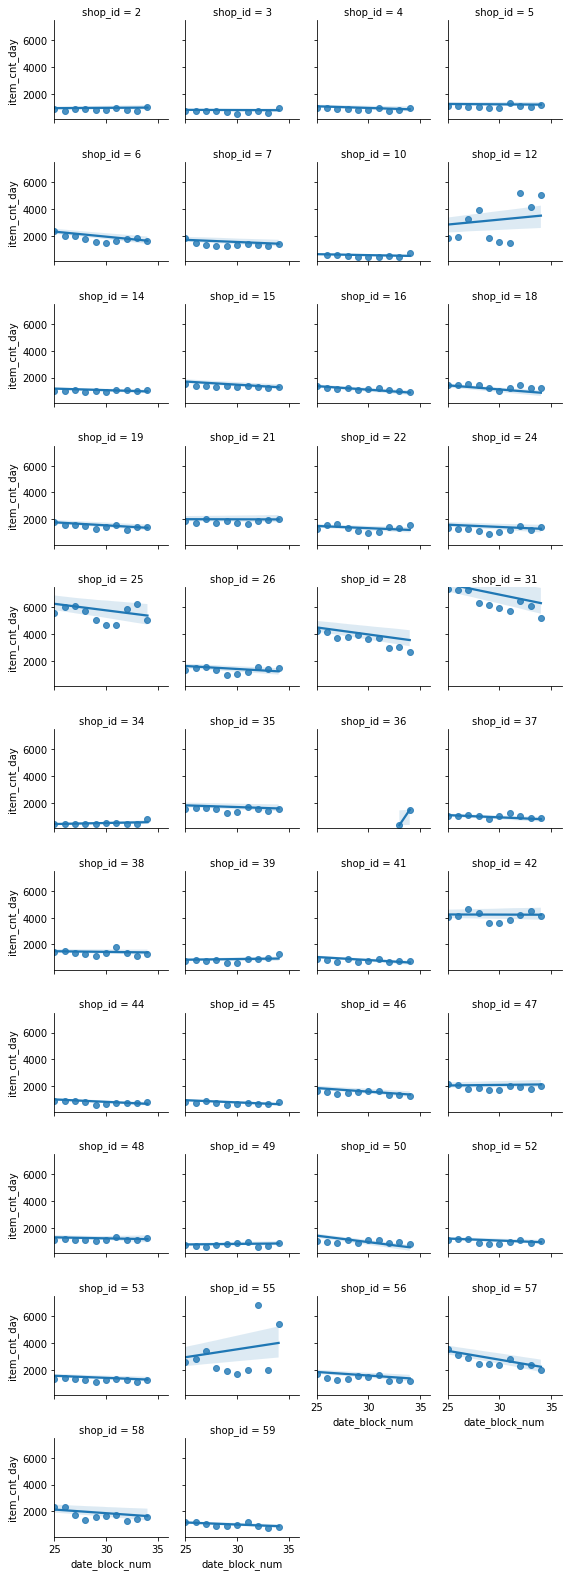

In [26]:
#Check results
test_res_grouped = test_res.groupby(["shop_id"], as_index=False)["final_res"].sum()
test_res_grouped["date_block_num"] = 34
test_res_grouped.rename(columns = {'final_res' : 'item_cnt_day'}, inplace = True)
train_test_res = pd.concat([stg_dsi,test_res_grouped])
print(train_test_res.head())
print(train_test_res.tail())

#solds every shops
print("*** All shops ***")   
g = sns.FacetGrid(train_test_res, col="shop_id", col_wrap=4, height=2, xlim=(25, 36), ylim=(100, 7500))
g.map(sns.regplot, "date_block_num", "item_cnt_day") #, order=[1, 2, 3], color=".3", ci=None)

Text(0.5, 0.98, 'Solds of item 20949 at Shop 31 at 11/2015')

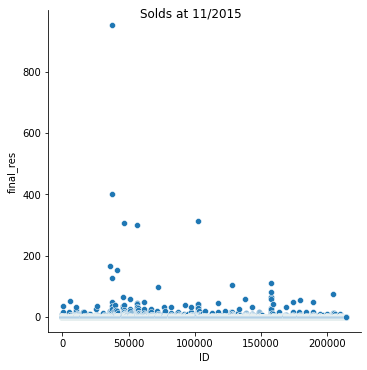

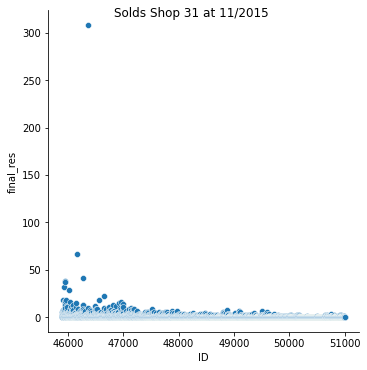

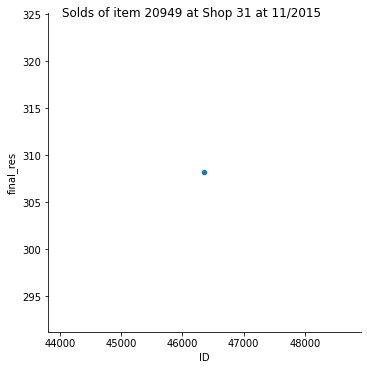

In [27]:
#TOTAL SOLDS AT NOV 2015
fig7 = sns.relplot(x='ID', y='final_res', data=test_res)
fig7a = fig7.fig 
fig7a.suptitle("Solds at 11/2015", fontsize=12)

#SHOPS SOLD PER SHOP 31
fig9 = sns.relplot(x='ID', y='final_res', data=test_res.loc[test_res['shop_id'] == 31])
fig9a = fig9.fig 
fig9a.suptitle("Solds Shop 31 at 11/2015", fontsize=12)

#TEMS SOLD AT SHOP 31
fig10 = sns.relplot(x='ID', y='final_res', data=test_res.loc[(test_res['item_id'] == 20949) & (test_res['shop_id'] == 31)])
fig10a = fig10.fig 
fig10a.suptitle("Solds of item 20949 at Shop 31 at 11/2015", fontsize=12)


In [28]:
#Submission table
submit = test_res[['ID','final_res']]
submit.columns= ['ID','item_cnt_month']

#True target values are clipped into [0,20] range.
print("Clip into [0,20] range")
submit['item_cnt_month'][submit['item_cnt_month'] > 20] = 20
submit['item_cnt_month'][submit['item_cnt_month'] < 0] = 0
print(submit.head(10))
print(submit.tail(10))
print("Final checks")
print(submit[46359:46362])
print(submit[45:55])
print(submit[460:465])

print("Final total sells estimated, after clip = ", submit['item_cnt_month'].sum())

submit.to_csv('submission.csv', index=False)

Clip into [0,20] range
   ID  item_cnt_month
0   0        0.865582
1   1        0.109227
2   2        1.081977
3   3        0.216395
4   4        0.109227
5   5        0.432791
6   6        1.081977
7   7        0.216395
8   8        2.163955
9   9        0.109227
            ID  item_cnt_month
214190  214190        0.081777
214191  214191        0.081777
214192  214192        0.081777
214193  214193        0.081777
214194  214194        0.081777
214195  214195        0.199424
214196  214196        0.081777
214197  214197        0.081777
214198  214198        0.081777
214199  214199        0.081777
Final checks
          ID  item_cnt_month
46359  46359        1.609933
46360  46360       20.000000
46361  46361        4.829798
    ID  item_cnt_month
45  45        0.109227
46  46        1.081977
47  47        0.109227
48  48        0.216395
49  49        1.298373
50  50        2.380350
51  51        0.216395
52  52        0.432791
53  53        0.216395
54  54        5.409887
      ID  it

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/serie